# Dog Breed Identification
## Farhad Navid 

### transfer learning with original data set

* Load data set
* Load weights from ImageNet features for pretrained VGG19 model "block4_pool".
* Run model
* Create train and test
* Run SVM model
* Record the performance. 

In [1]:
# initialization
import matplotlib.pyplot as plt 
import PIL
import pandas as pd
import os
import glob
import time
import numpy as np
import h5py
import tensorflow as tf
#import deepdish as dd

from array import *
from PIL import Image as Img

from tqdm import tqdm
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D 

from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score,confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split


%matplotlib inline
K.set_image_dim_ordering( 'tf' )

Using TensorFlow backend.


This next block of code does represent the Directory structure of the data once the repository was selected.  In this instance the [**AWS**](https://www.AWS.Amazon.com/) (paid service) were utilized.  

In [2]:
# directory structure of the data

dpath_train = '/home/ubuntu/train'      # Data path to training data set
dpath_test  = '/home/ubuntu/test'       # Data path to test data set
dpath       = '/home/ubuntu'
label_f     = '/home/ubuntu/labels.csv' # Path to the label file 

**Load the augmented data file** 

In [3]:
# now read to hdf5 
#The processed train data set file  that was created by input_prep file.
with h5py.File('train_data.hdf5','r') as f:
    X_train = f['X'][()] #the [()] means load all x_train data
    y_train = f['Y'][()] # Load all y_train data
print(X_train.shape,X_train.dtype,y_train.shape,y_train.dtype)

(10222, 224, 224, 3) uint8 (10222, 120) uint8


In [4]:
print(X_train.shape,X_train.dtype,y_train.shape,y_train.dtype)
# y_train=y_train.astype('uint8')
#y_train[:5]

(10222, 224, 224, 3) uint8 (10222, 120) uint8


In [5]:
# converting the y_train from one hot encoding to integer
ytrain_1 = np.array(y_train)
ytrain1_rdy = [np.where(r==1)[0][0] for r in ytrain_1]

In [6]:
y_train = ytrain1_rdy

In [7]:
ytrain1_rdy=np.array(ytrain1_rdy)
ytrain1_rdy[:5]

array([19, 37, 85, 15, 49])

### Transfer Learning
* **Used the fc2 weights instead of Block4_pool feature.  this reduced the feature size significantly.**

In [8]:
# transfer learning
# Get the weights from imagenet for the VGG19 model
base_model = VGG19(weights='imagenet')
# now select the layer to get the features from in this case "block4_pool" was selected
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Create a zero Numpy array with the shape of np.zero((Xs_train.shape[0],(block4_pool_features))) 
# for this modle the (image#,14,14,512)

# train_set = np.zeros((X_train.shape[0],14,14,512))
train_set = np.zeros((X_train.shape[0],4096))
# block4_pool_features_org = model.predict(x)  # Create one entry to see the shape

# this loop will fill the train_set numpy array (each x_train runs through model with extracted VGG features)
for i in tqdm(range(X_train.shape[0])):
#    K.clear_session()
    x = preprocess_input(X_train[i])
    x = np.expand_dims(x,axis=0)
    block4_pool_features = model.predict(x)
    train_set[i]=block4_pool_features
    

100%|██████████| 10222/10222 [05:34<00:00, 30.58it/s]


In [9]:
# Create train and test data set
train_set = train_set.reshape(train_set.shape[0],-1)
X_train= train_set
y_train= ytrain1_rdy

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.06, random_state=42)

In [13]:
# Now let's make sure we have all the unique dog names identified and chk the total number.

unique_Dog_Breed = []
for i in y_train:
    if i not in unique_Dog_Breed:
        unique_Dog_Breed.append(i)
    
unique_Dog_Breed.sort()   # Now sort the unique lable alphabatically. Next we need to count howmany unique label

count = 0
unique_Dog_Breed_Num = []   # integer assiciated with every unique Dog name

# with the next loops we are creating integers for each unique labels. in prepration of catagorizing the Y.

for i in unique_Dog_Breed:
    unique_Dog_Breed_Num.append([i, count])
    count += 1

for i in range(len(y_train)):
    for j in unique_Dog_Breed_Num:
        if y_train[i] == j[0]:
            y_train[i] = j[1]
            break

print("unique Dog Breed Numbers = ",len(unique_Dog_Breed_Num))

unique Dog Breed Numbers =  120


In [10]:
X_train.shape

(10222, 4096)

### Create Train and Test data set for SVM model

In [11]:
# Split the train data to train and test 90/10

X = X_train
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## SVM model
* **Model Fit**
* **Model Prediction**

In [12]:
# Run the svm 
from sklearn import svm
t0=time.time()
clf = SVC()
clf.fit(X_train, y_train)
t1=time.time()
print(t1-t0,"seconds")

# predict 
t0=time.time()
pred_Train=clf.predict(X_train) 
pred_Test=clf.predict(X_test) 
t1=time.time()
print(t1-t0,"seconds")

# print(pred_Train[:10],pred_Test[:10])
# print(clf.predict([train_set[5]]))

609.0376780033112 seconds
456.5456712245941 seconds


## Performance
* Cohen's Kappa Score
* Accuracy score
* classification report
* F1 Score
* confusion matrix (This matrix was not selected since the entire model did not run and result was not as interesting)

In [14]:
print(cohen_kappa_score(y_train, pred_Train),'Train data set cohen kappa score')
print(cohen_kappa_score(y_test, pred_Test),'Test data set cohen kappa score')

#confusion_matrix(y_train, pred_Train)

print(accuracy_score(y_train, pred_Train),'Accuracy Score Train Data set')
print(accuracy_score(y_test, pred_Test), 'Accuracy Score Test Data set')

print(classification_report(y_train, pred_Train))
print(classification_report(y_test, pred_Test))

print(metrics.f1_score(y_train, pred_Train,average='weighted'),'matrics f1 score train data set')
print(metrics.f1_score(y_test, pred_Test,average='weighted'),'matrics f1 score test data set')

0.9779616233107558 Train data set cohen kappa score
0.7572553411290812 Test data set cohen kappa score
0.9781497988911838 Accuracy Score Train Data set
0.7595307917888563 Accuracy Score Test Data set
             precision    recall  f1-score   support

          0       0.99      0.99      0.99        71
          1       1.00      0.99      1.00       107
          2       0.99      1.00      0.99        75
          3       0.94      0.99      0.96        95
          4       0.99      0.96      0.97        69
          5       1.00      0.93      0.96        70
          6       0.95      0.93      0.94        90
          7       0.99      0.99      0.99       102
          8       0.99      1.00      0.99        76
          9       0.96      0.99      0.97        95
         10       0.99      1.00      0.99        71
         11       0.93      1.00      0.97        99
         12       0.99      0.99      0.99        71
         13       0.98      1.00      0.99        87
    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Ploting the Confusion Matrix
* **The Plotting routine was barrowed [Source](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)** 

In [15]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

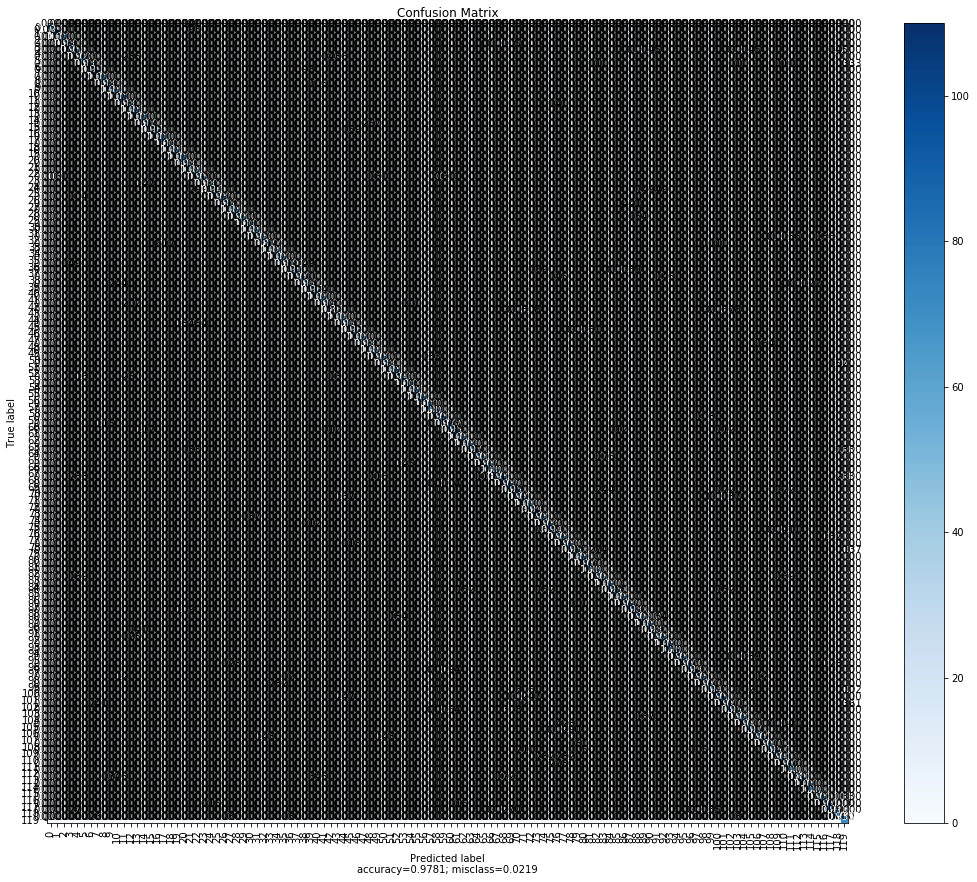

In [16]:
plot_confusion_matrix(cm           = confusion_matrix(y_train, pred_Train), 
                      normalize    = True,
                      target_names = unique_Dog_Breed,
                      title        = "Confusion Matrix")